# Introduction

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

We need to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most based on the dataset provided.

# Import modules

In [1]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt


import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

# Get the Data

In [2]:
#load the dataset
df = pd.read_csv("Country-data.csv")
#Exports, Imports and Health values are given in percentage of GDP
df['exports'] = df['exports']*df['gdpp']/100
df['imports'] = df['imports']*df['gdpp']/100
df['health'] = df['health']*df['gdpp']/100
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [4]:
#167 rows with 10 columns
df.shape

(167, 10)

In [5]:
# No missing values
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

# Data Analysis

#### Child mortality majorly lies between 19 to 62 and few datapoints outside the whiskers

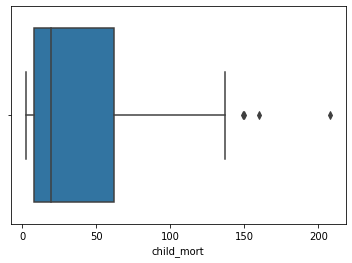

In [6]:
df.child_mort.describe()
df.child_mort.quantile([0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
sns.boxplot(df.child_mort)
plt.show()

    Exports: Outliers observed

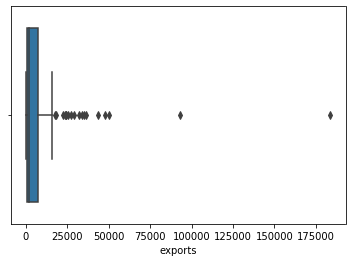

In [7]:
sns.boxplot(df.exports)
plt.show()

##### Health: Most of the values are greater than median with outliers ..

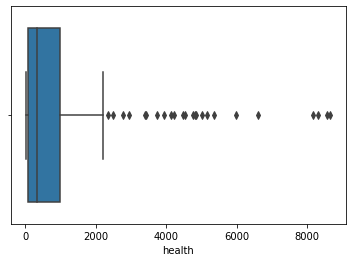

In [8]:
sns.boxplot(df.health)
plt.show()

Imports: Outliers observed as seen below in imports

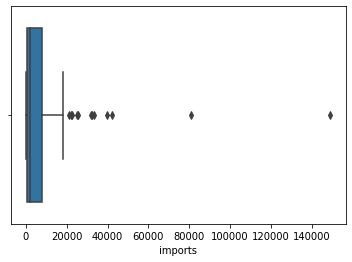

In [9]:
sns.boxplot(df.imports)
plt.show()

Income: Although the median is 10K, most of the data is greater than median with outliers

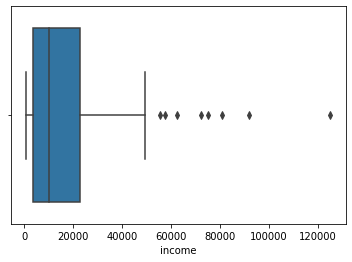

In [10]:
sns.boxplot(df.income)
plt.show()

Inflation: Consistent with some outliers

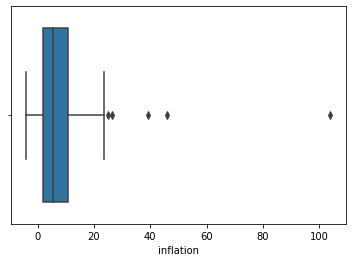

In [11]:
sns.boxplot(df.inflation)
plt.show()

Life Expectancy: Median is around 75, but there are many lower life expectancy as outliers

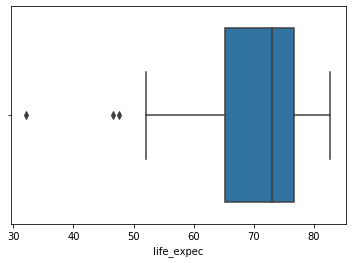

In [12]:
sns.boxplot(df.life_expec)
plt.show()

Total fertility: IQR between 2 to 4 with hardly any outlier

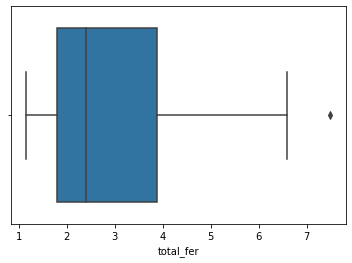

In [13]:
sns.boxplot(df.total_fer)
plt.show()

GDPP: Many outliers in the higher range, although the median value is around 4660

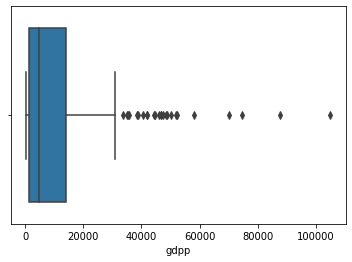

In [14]:
sns.boxplot(df.gdpp)
plt.show()

#### There are outliers present. Capping the higher outliers for gdpp, infllation is a good approach. For child mortality higher outlier should not be capped as it is relevant to identify them for aid 

In [15]:
q99= df.gdpp.quantile(0.99)
q99

79088.00000000004

In [16]:
df['gdpp'][df['gdpp']>q99]=q99

In [17]:
qi99= df.income.quantile(.99)
df['income'][df['income']>qi99]=qi99

In [18]:
qim99= df.imports.quantile(.99)
df['imports'][df['imports']>qim99]=qim99

In [19]:
qe99= df.exports.quantile(.99)
df['exports'][df['exports']>qe99]=qe99

In [20]:
qh99= df.health.quantile(.99)
df['health'][df['health']>qh99]=qh99

Analysis of distribution plot:
Variation is observed in child_mort, income, life_expec (left skewed), total_fer and gdpp and 
we can see around 2 to 4 peaks. 

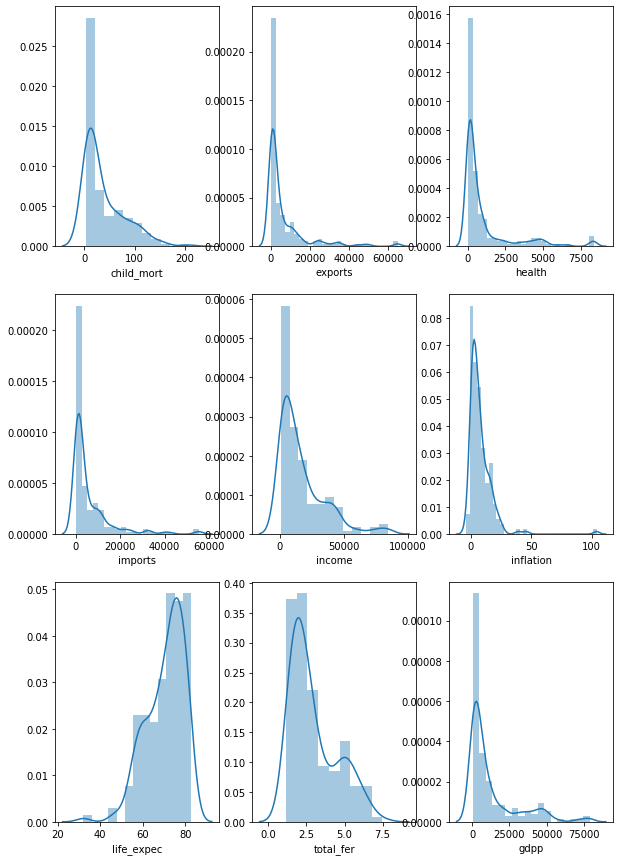

In [21]:
# Variation is observed in child_mort, income, life_expec (left skewed), total_fer and gdpp and we can see around 2 to 3 peaks. 
col=['child_mort','exports','health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer','gdpp']
plt.figure(figsize=(10,15))
for i in enumerate(col):
    plt.subplot(3,3,i[0]+1)
    sns.distplot(df[i[1]])
    
#for i in enumerate(col):
    #print(i)

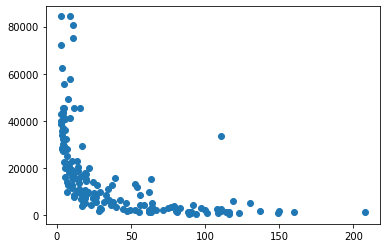

In [22]:
# The relationship between child_mortality and income is inverse. Higher income lower child mortality
plt.scatter(df.child_mort, df.income)

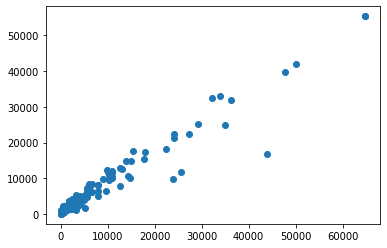

In [23]:
# Exports and Imports are postively correlated
plt.scatter(df.exports, df.imports)

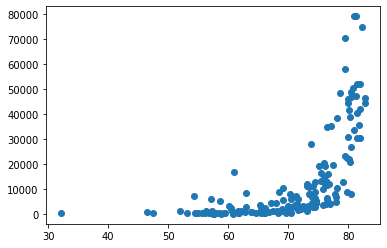

In [24]:
# Higher gdpp higher life expectancy
plt.scatter(df.life_expec, df.gdpp)

### Preprocess Data

In [25]:
# Focus on child_mort, income and gdpp
df_data = df[['child_mort','exports','health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer','gdpp']]    
df_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0
1,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0
2,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0
3,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0
4,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0


In [26]:
##  Hopkins 5625

#### Perform scaling as part of preprocessing

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit_transform
df_data_scaled = scaler.fit_transform(df_data)
df_data_scaled.shape

(167, 9)

In [28]:
df_data_scaled = pd.DataFrame(df_data_scaled)
df_data_scaled.columns = ['child_mort','exports','health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer','gdpp']
features = df_data_scaled.columns

#### Visualize feature distributions

We can notice that we have a **skewed distribution** of the 3 variables and there exist **outliers**.

This indicates how normalization is required to make the data features normally distributed as **clustering** algorithms **require** them to be **normally distributed**.

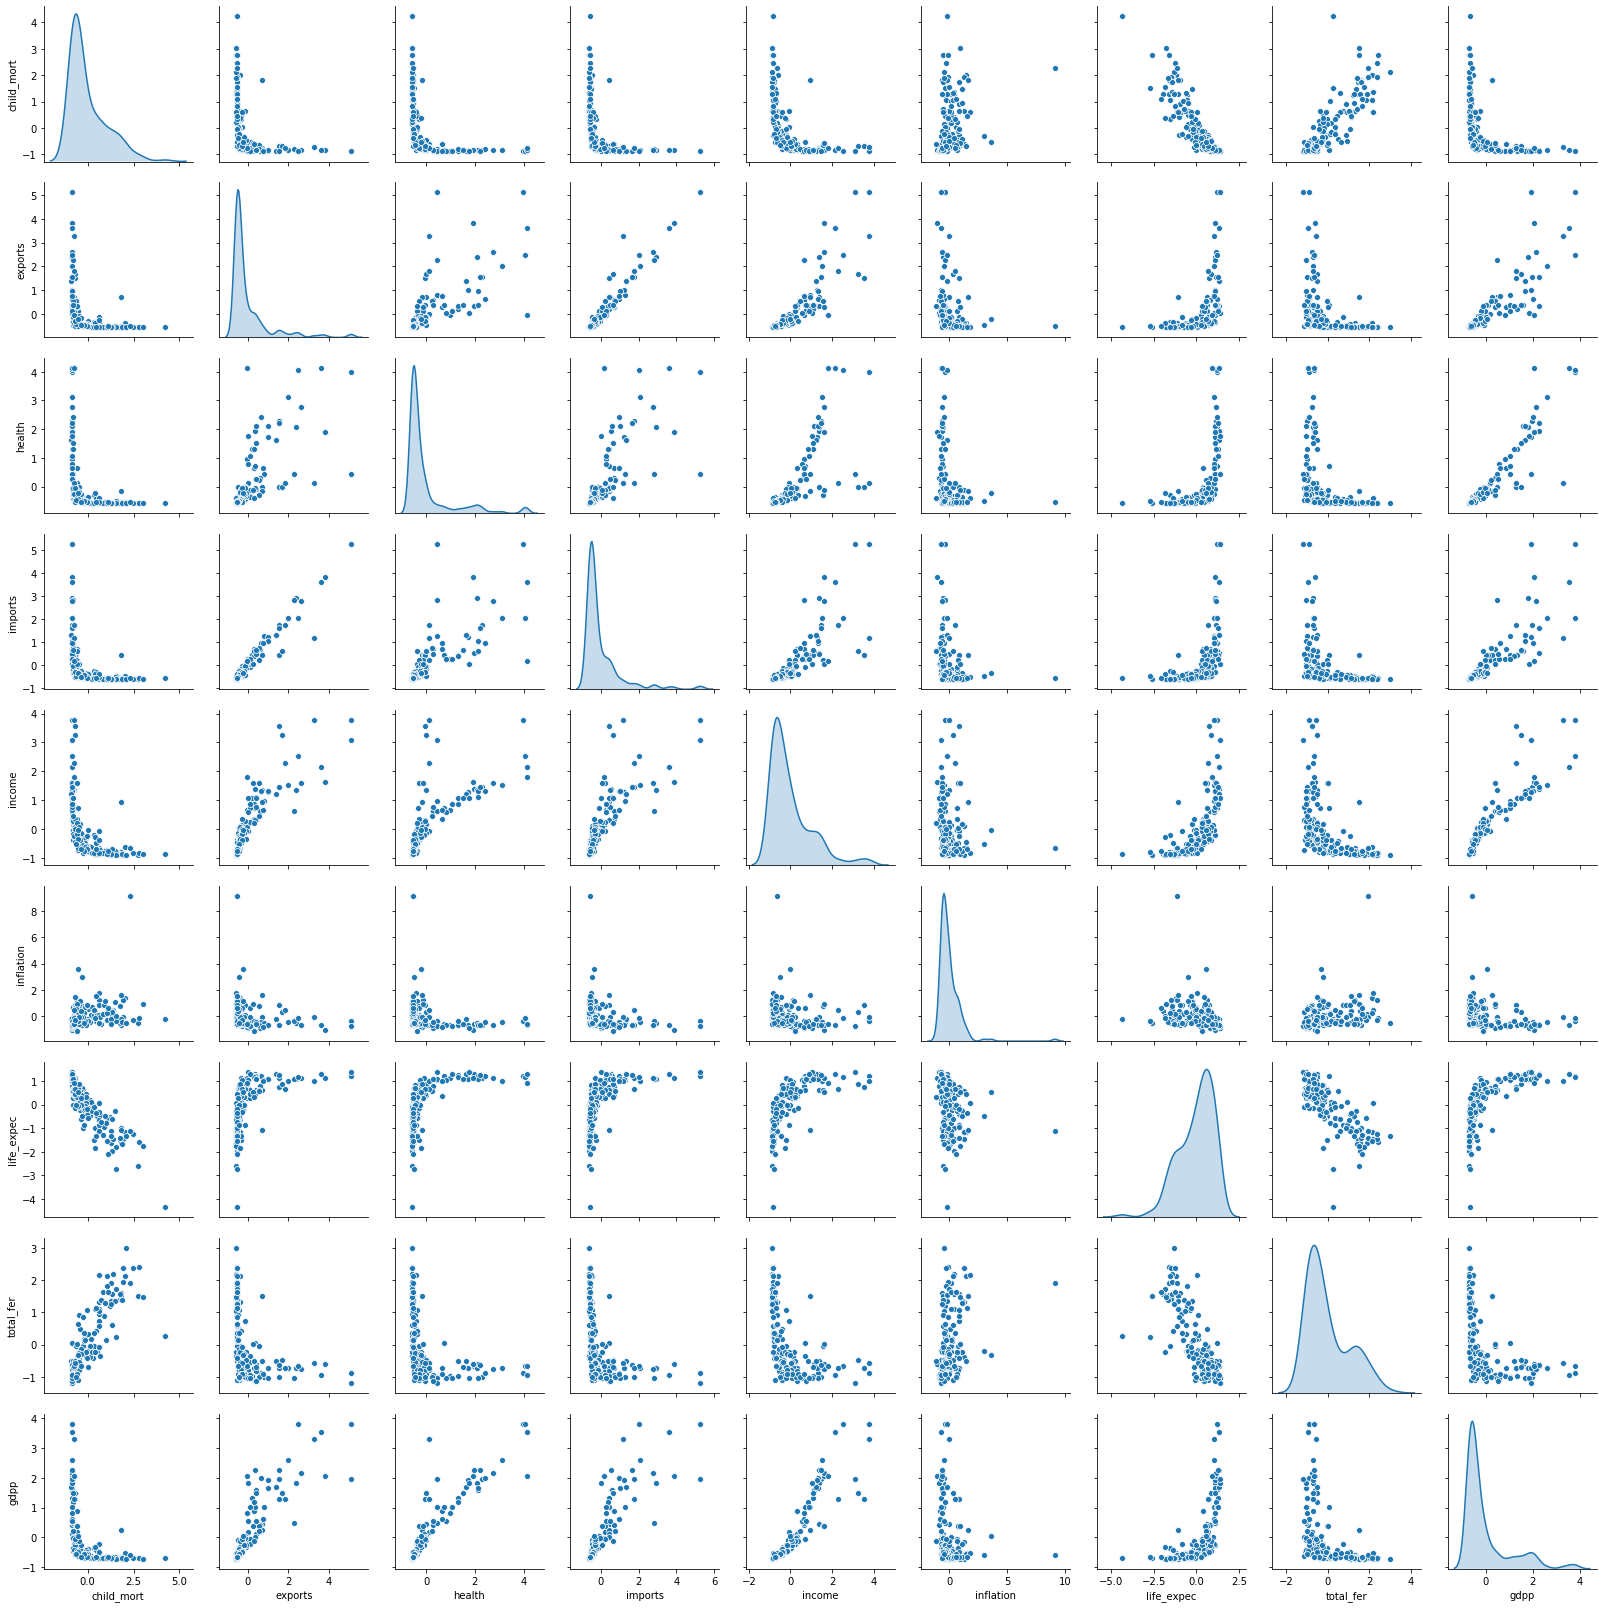

In [29]:
sns.pairplot(df_data_scaled, diag_kind='kde')

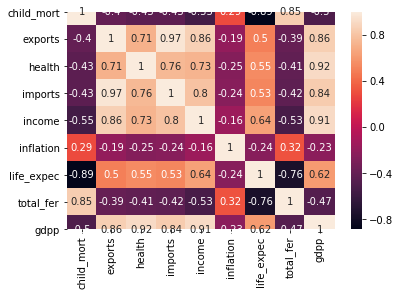

In [30]:
sns.heatmap(df_data_scaled.corr(),annot=True)

PowerTransformer helps attain Normal Distribution

In [31]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
df_data_scaled = pd.DataFrame(pt.fit_transform(df_data_scaled))
df_data_scaled.columns = features
df_data_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.370383,-1.065608,-1.013379,-1.092108,-1.235169,0.640750,-1.461531,1.562228,-1.130973
1,-0.427361,-0.607650,-0.410155,-0.331634,-0.153769,-0.173150,0.599220,-1.009352,-0.420531
2,0.086520,-0.395505,-0.614410,-0.565957,0.138254,1.239008,0.632570,0.315649,-0.355866
3,1.611745,-0.227110,-0.844547,-0.518775,-0.627910,1.587848,-1.191690,1.647317,-0.521766
4,-0.791929,0.635242,0.481320,0.935379,0.600231,-0.921888,0.683137,-0.408705,0.631962


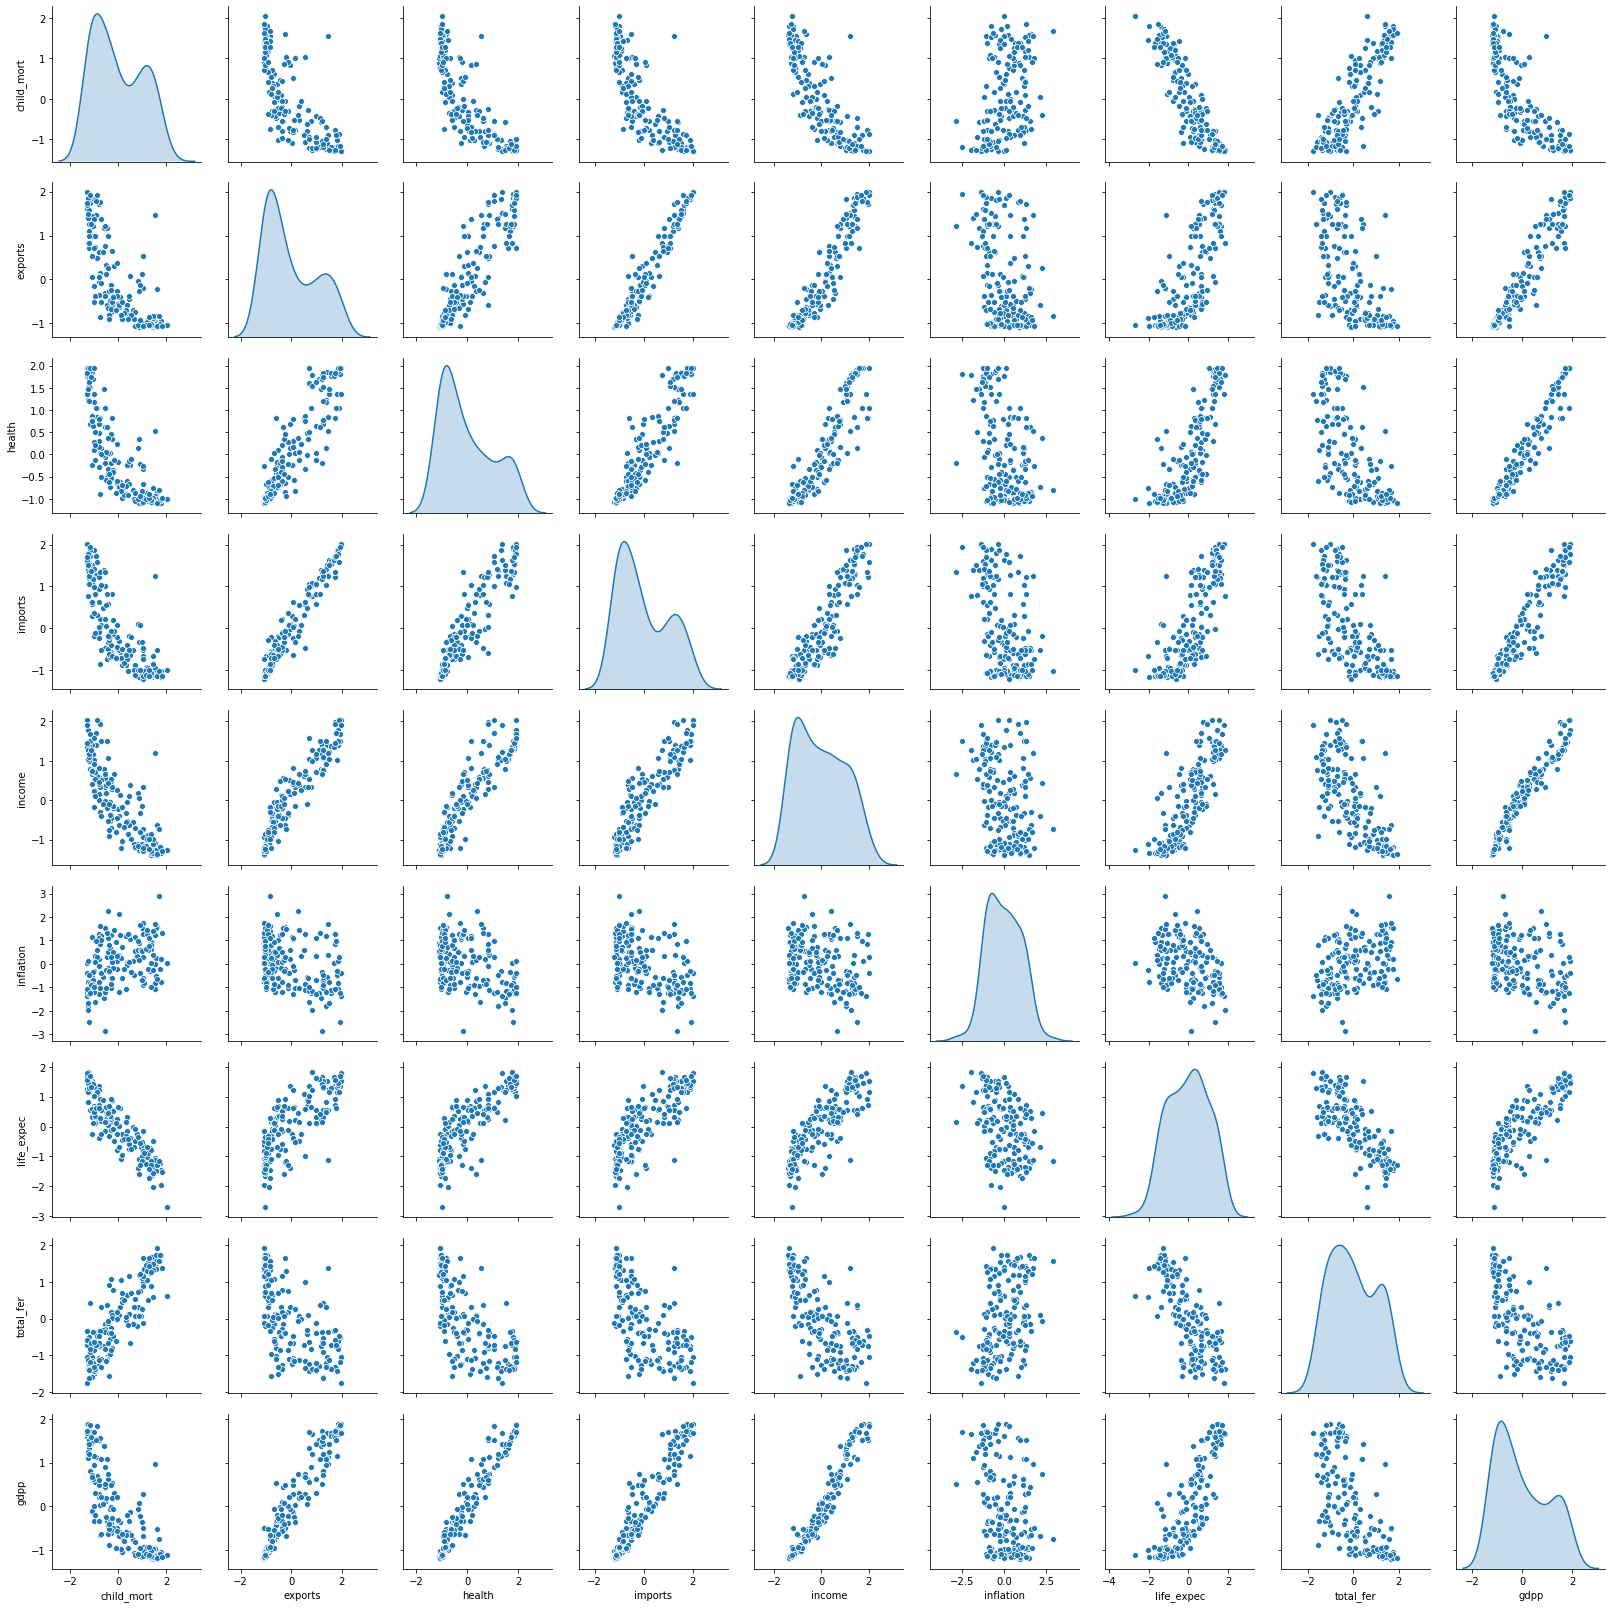

In [32]:
sns.pairplot(df_data_scaled,diag_kind='kde')

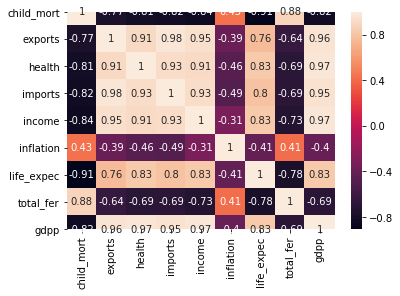

In [33]:
sns.heatmap(df_data_scaled.corr(),annot=True)

### K-means Implementation

A common challenge with k-means is that you must tell it how many clusters you expect. Figuring out how many clusters we need is not obvious from data, thus we will try different clusters numbers and check their [silhouette coefficient](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). The [elbow](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method) method can be used to determine the number of clusters as well.

**Note:** K-means is sensitive to initializations because those initializations are critical to quality of optima found. Thus, we will use smart initialization called ***k-means++***.

Finding the Optimal Number of Clusters

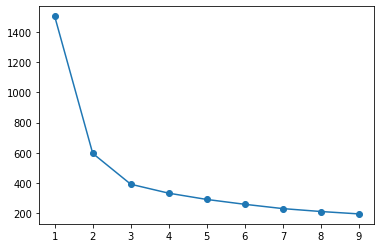

In [34]:
# elbow-curve/SSD
ssd = []
range_n_clusters = range( 1, 10)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, n_init = 100,init='k-means++',random_state=0)
    kmeans.fit(df_data_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
ssd_df = pd.DataFrame( { "num_clusters":range_n_clusters, "ssd": ssd} )
plt.plot( ssd_df.num_clusters, ssd_df.ssd, marker = "o" )

Silhouette Analysis
silhouette score=(𝑝−𝑞)/𝑚𝑎𝑥(𝑝,𝑞)
 
𝑝  is the mean distance to the points in the nearest cluster that the data point is not a part of

𝑞  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [35]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_data_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_data_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.4857938055758658
For n_clusters=3, the silhouette score is 0.39911201062437685
For n_clusters=4, the silhouette score is 0.3298765437217506
For n_clusters=5, the silhouette score is 0.3349938483775409
For n_clusters=6, the silhouette score is 0.30333397175463284
For n_clusters=7, the silhouette score is 0.28988878748562513
For n_clusters=8, the silhouette score is 0.29835952588176284


In [37]:
# Number of clusters 3
kmeans = KMeans(n_clusters=3, n_init = 100,init='k-means++',random_state=0)
kmeans.fit(df_data_scaled)
# Getting the cluster labels
labels = kmeans.predict(df_data_scaled)

# assign the label
df_data_scaled['group'] = kmeans.labels_
df['group'] = kmeans.labels_

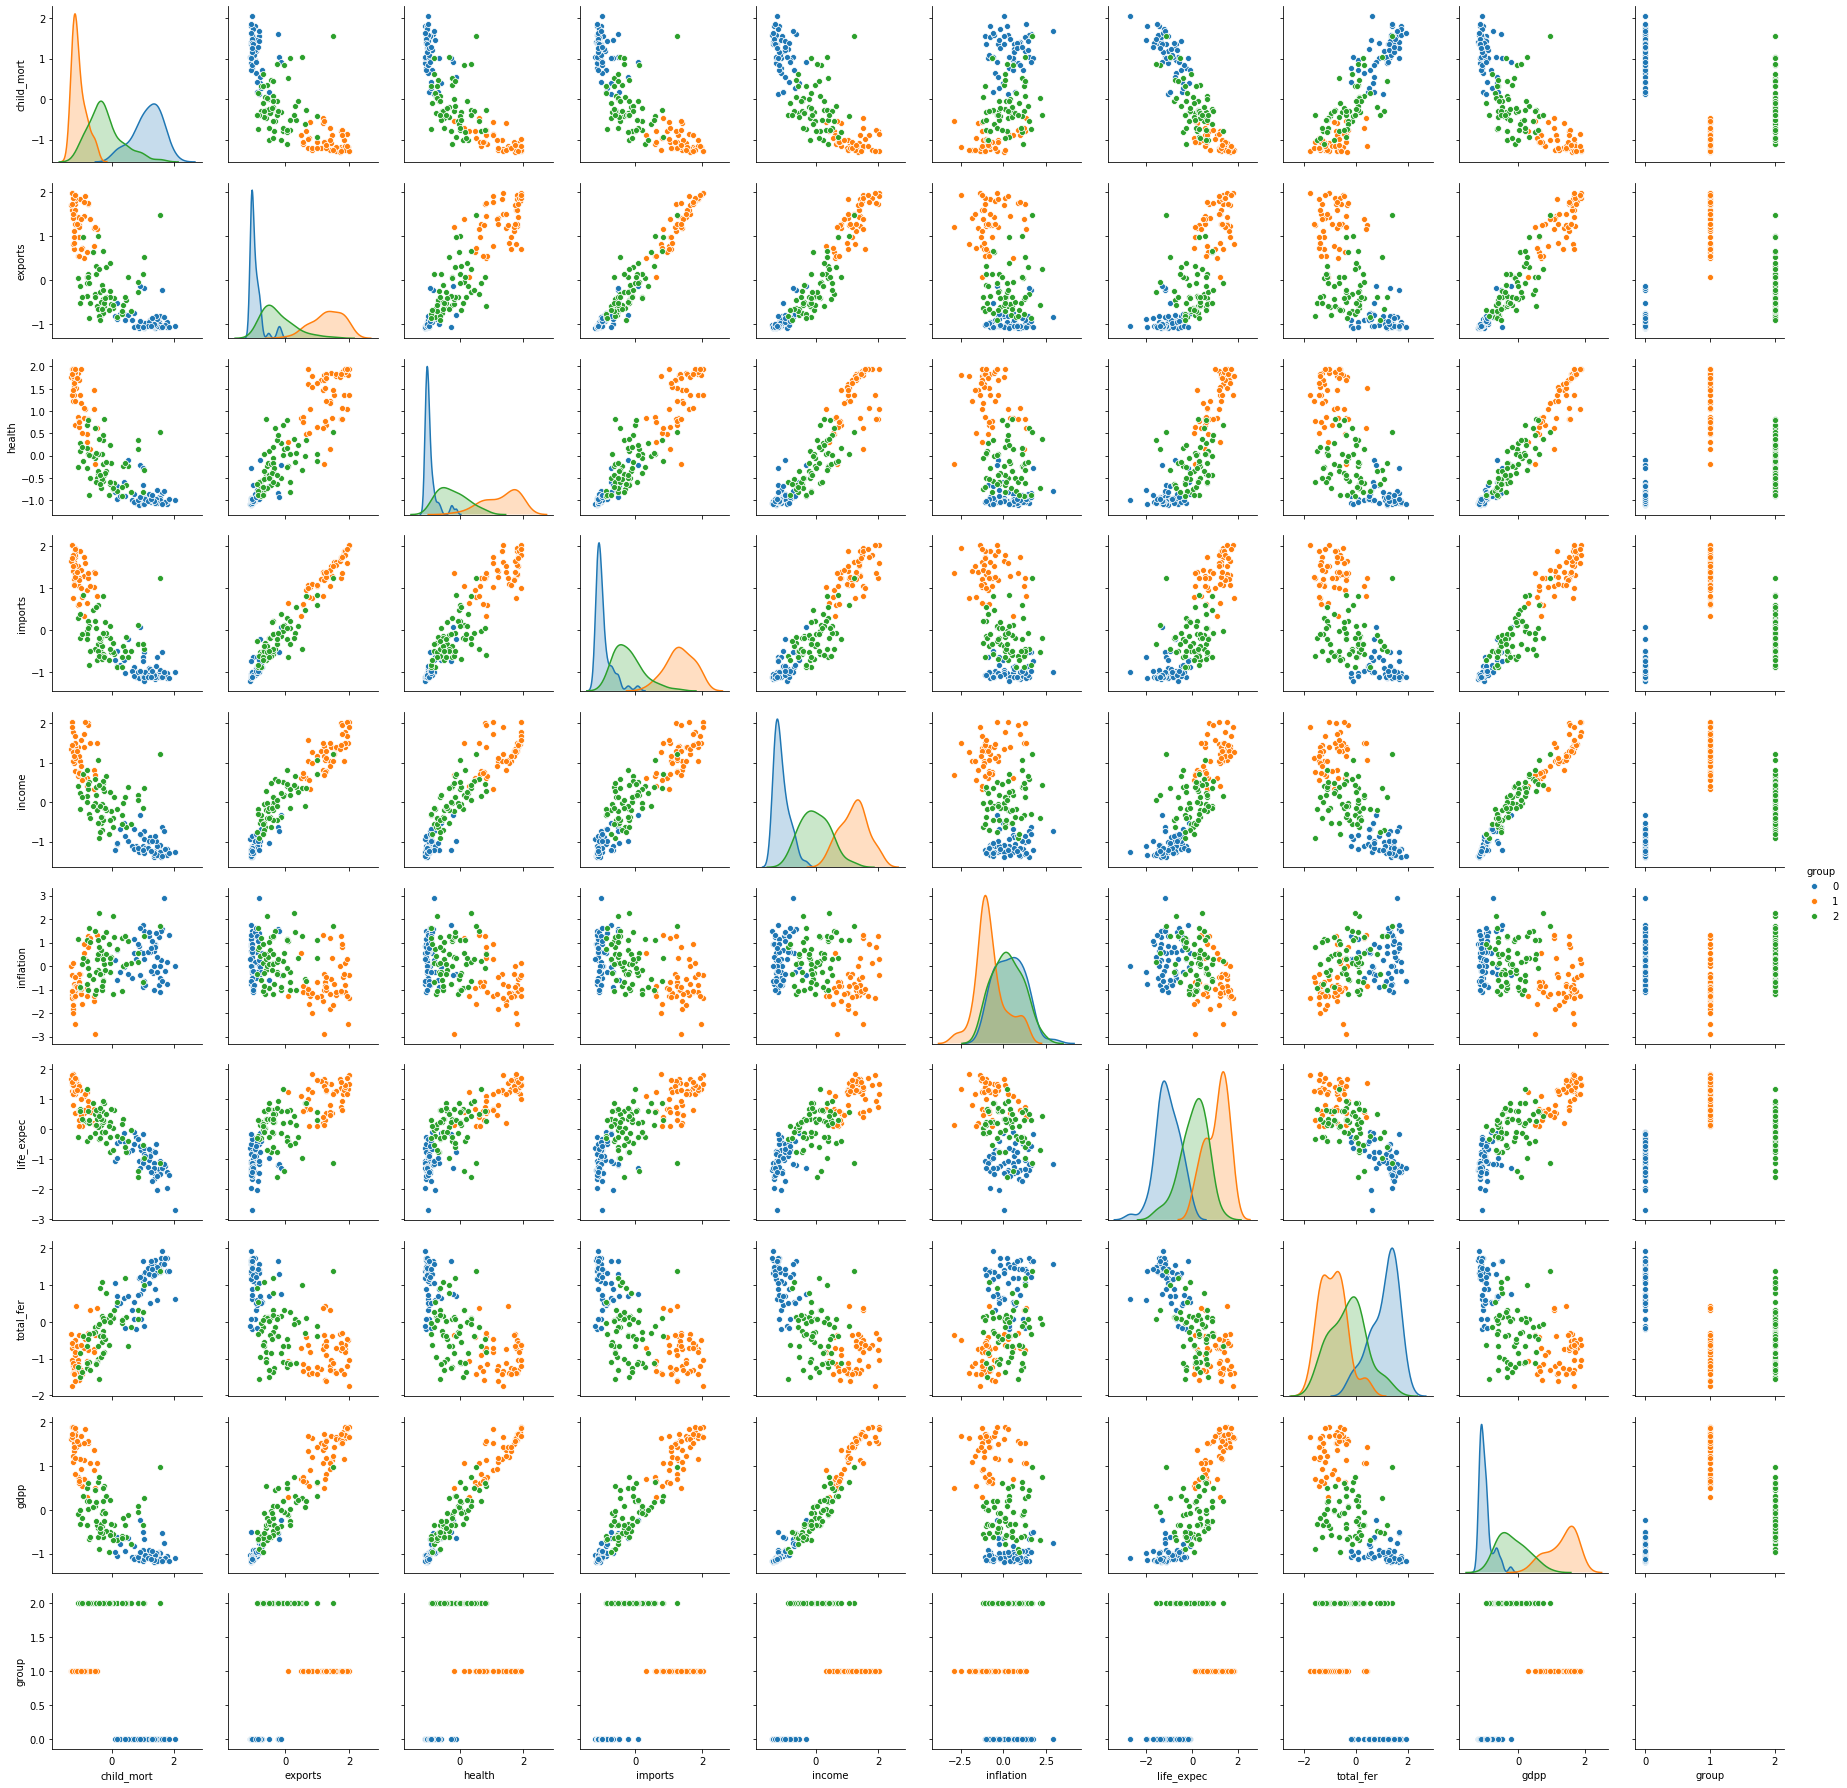

In [38]:
sns.pairplot(df_data_scaled,diag_kind='kde',hue='group')

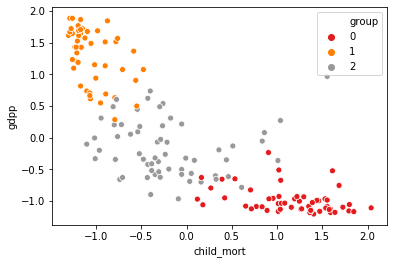

In [39]:
# Child_mortality is highest for Group 0 and lowest for Group 1, as gdpp increases child_mort decreases

sns.scatterplot(x="child_mort", y="gdpp", hue="group", data=df_data_scaled, palette="Set1")

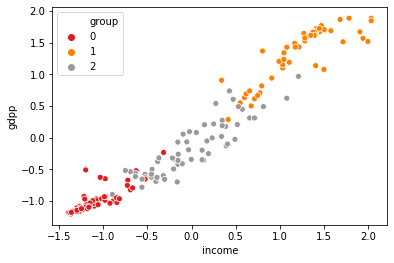

In [40]:
# GDPP and Income are positively correlated and is the highest for Group 1

sns.scatterplot(x="income", y="gdpp", hue="group", data=df_data_scaled, palette="Set1")

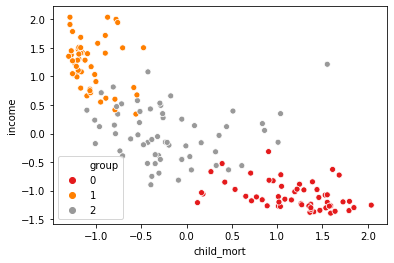

In [41]:
# More Income less Child_mortality. Income is the highest for Group 1 and lowest for Group 0

sns.scatterplot(x="child_mort", y="income", hue="group", data=df_data_scaled, palette="Set1")

#Group 0 - high child mortality, low gdpp, low income 
#Group 1 - low child mortality, high gdpp, high income 
#Group 2 - Low child mortality, low gdpp i.e. between Group 0 & 1

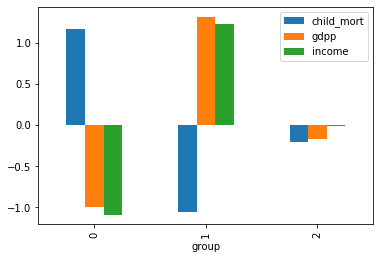

In [42]:
df_data_scaled.groupby("group")['child_mort', 'gdpp', 'income'].mean().plot(kind="bar")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002227F4E4DC8>,
      dtype=object)

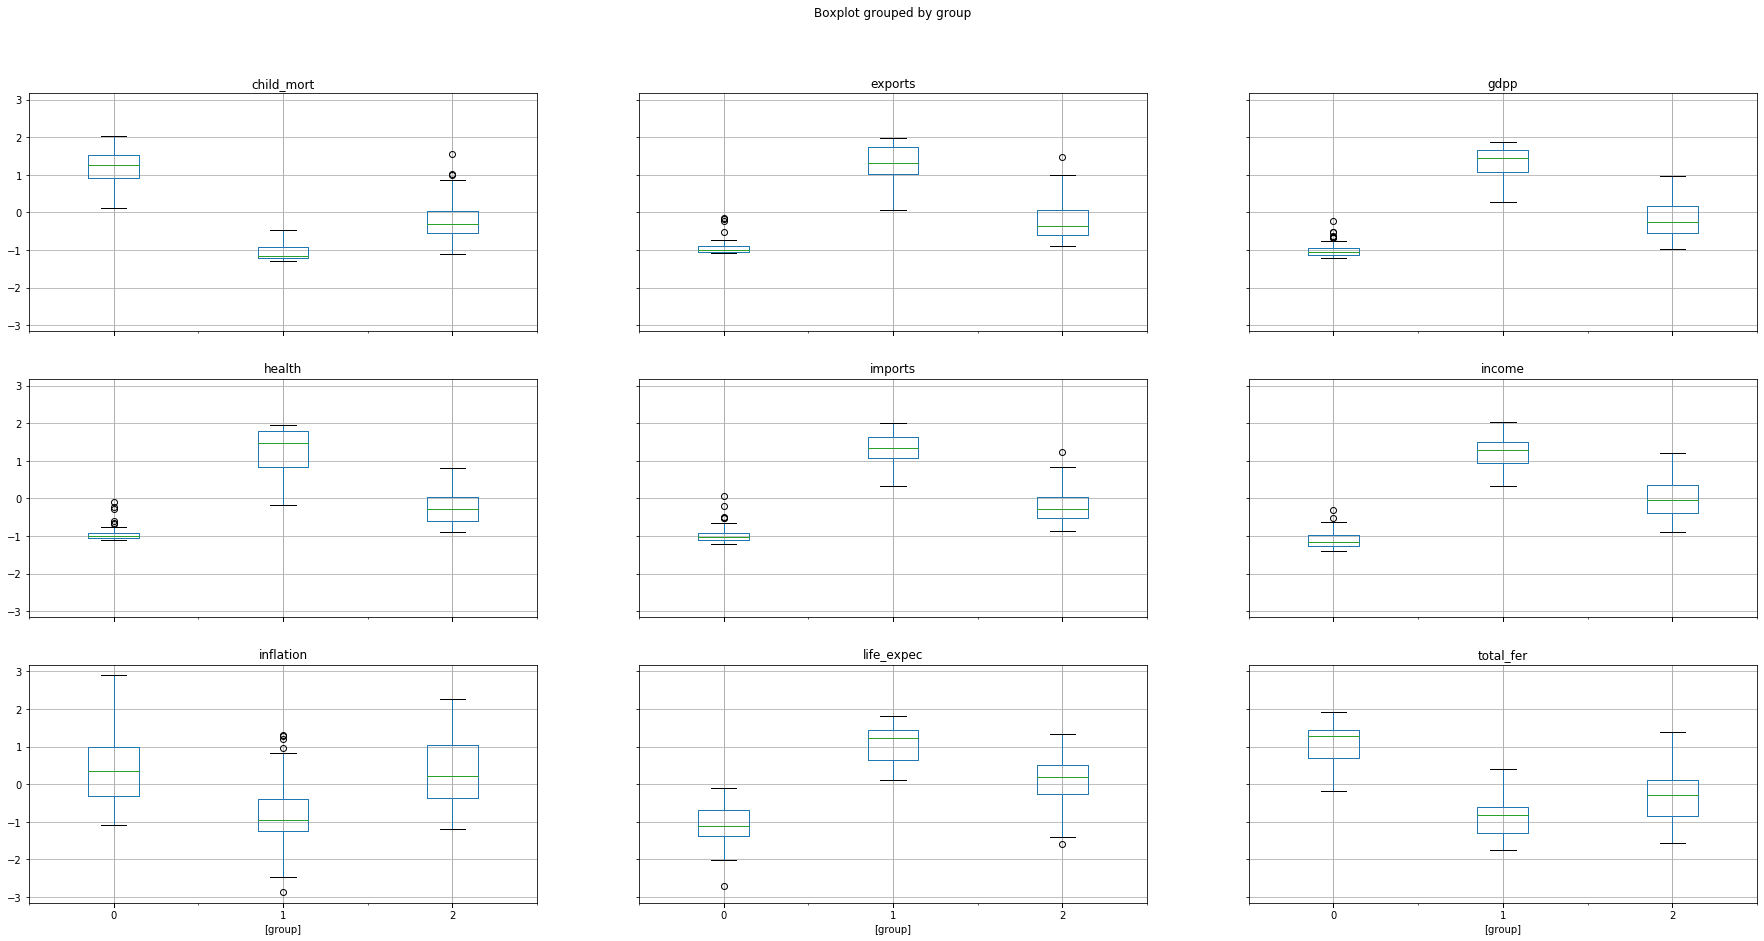

In [43]:
#Group 0 - high child mortality, low gdpp, low income, low life_expec, high total_fer, low import and export
#Group 1 - low child mortality, high gdpp, high income, low fertility, high life_expec and high import, export and health
#Group 2 - This has values intermediate between Group 2 and Group 1
df_data_scaled.boxplot(by = 'group',layout=(3,3), figsize=(30, 15))

In [54]:
# Identify top countries requiring aid
df[df.group==0].sort_values(by=['child_mort','gdpp','income'], ascending=[False, True, True]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels
66,Haiti,208.0,101.286,45.7442,428.314,1500.0,5.45,32.1,3.33,662.0,0,0
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0,0
32,Chad,150.0,330.096,40.6341,390.195,1930.0,6.39,56.5,6.59,897.0,0,0
31,Central African Republic,149.0,52.628,17.7508,118.190,888.0,2.01,47.5,5.21,446.0,0,0
97,Mali,137.0,161.424,35.2584,248.508,1870.0,4.37,59.5,6.55,708.0,0,0


In [ ]:
#Hierarchial

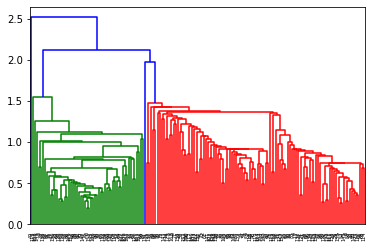

<Figure size 3600x2160 with 0 Axes>

In [45]:
# single linkage
mergings = linkage(df_data_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.figure(figsize=(50, 30))
plt.show()

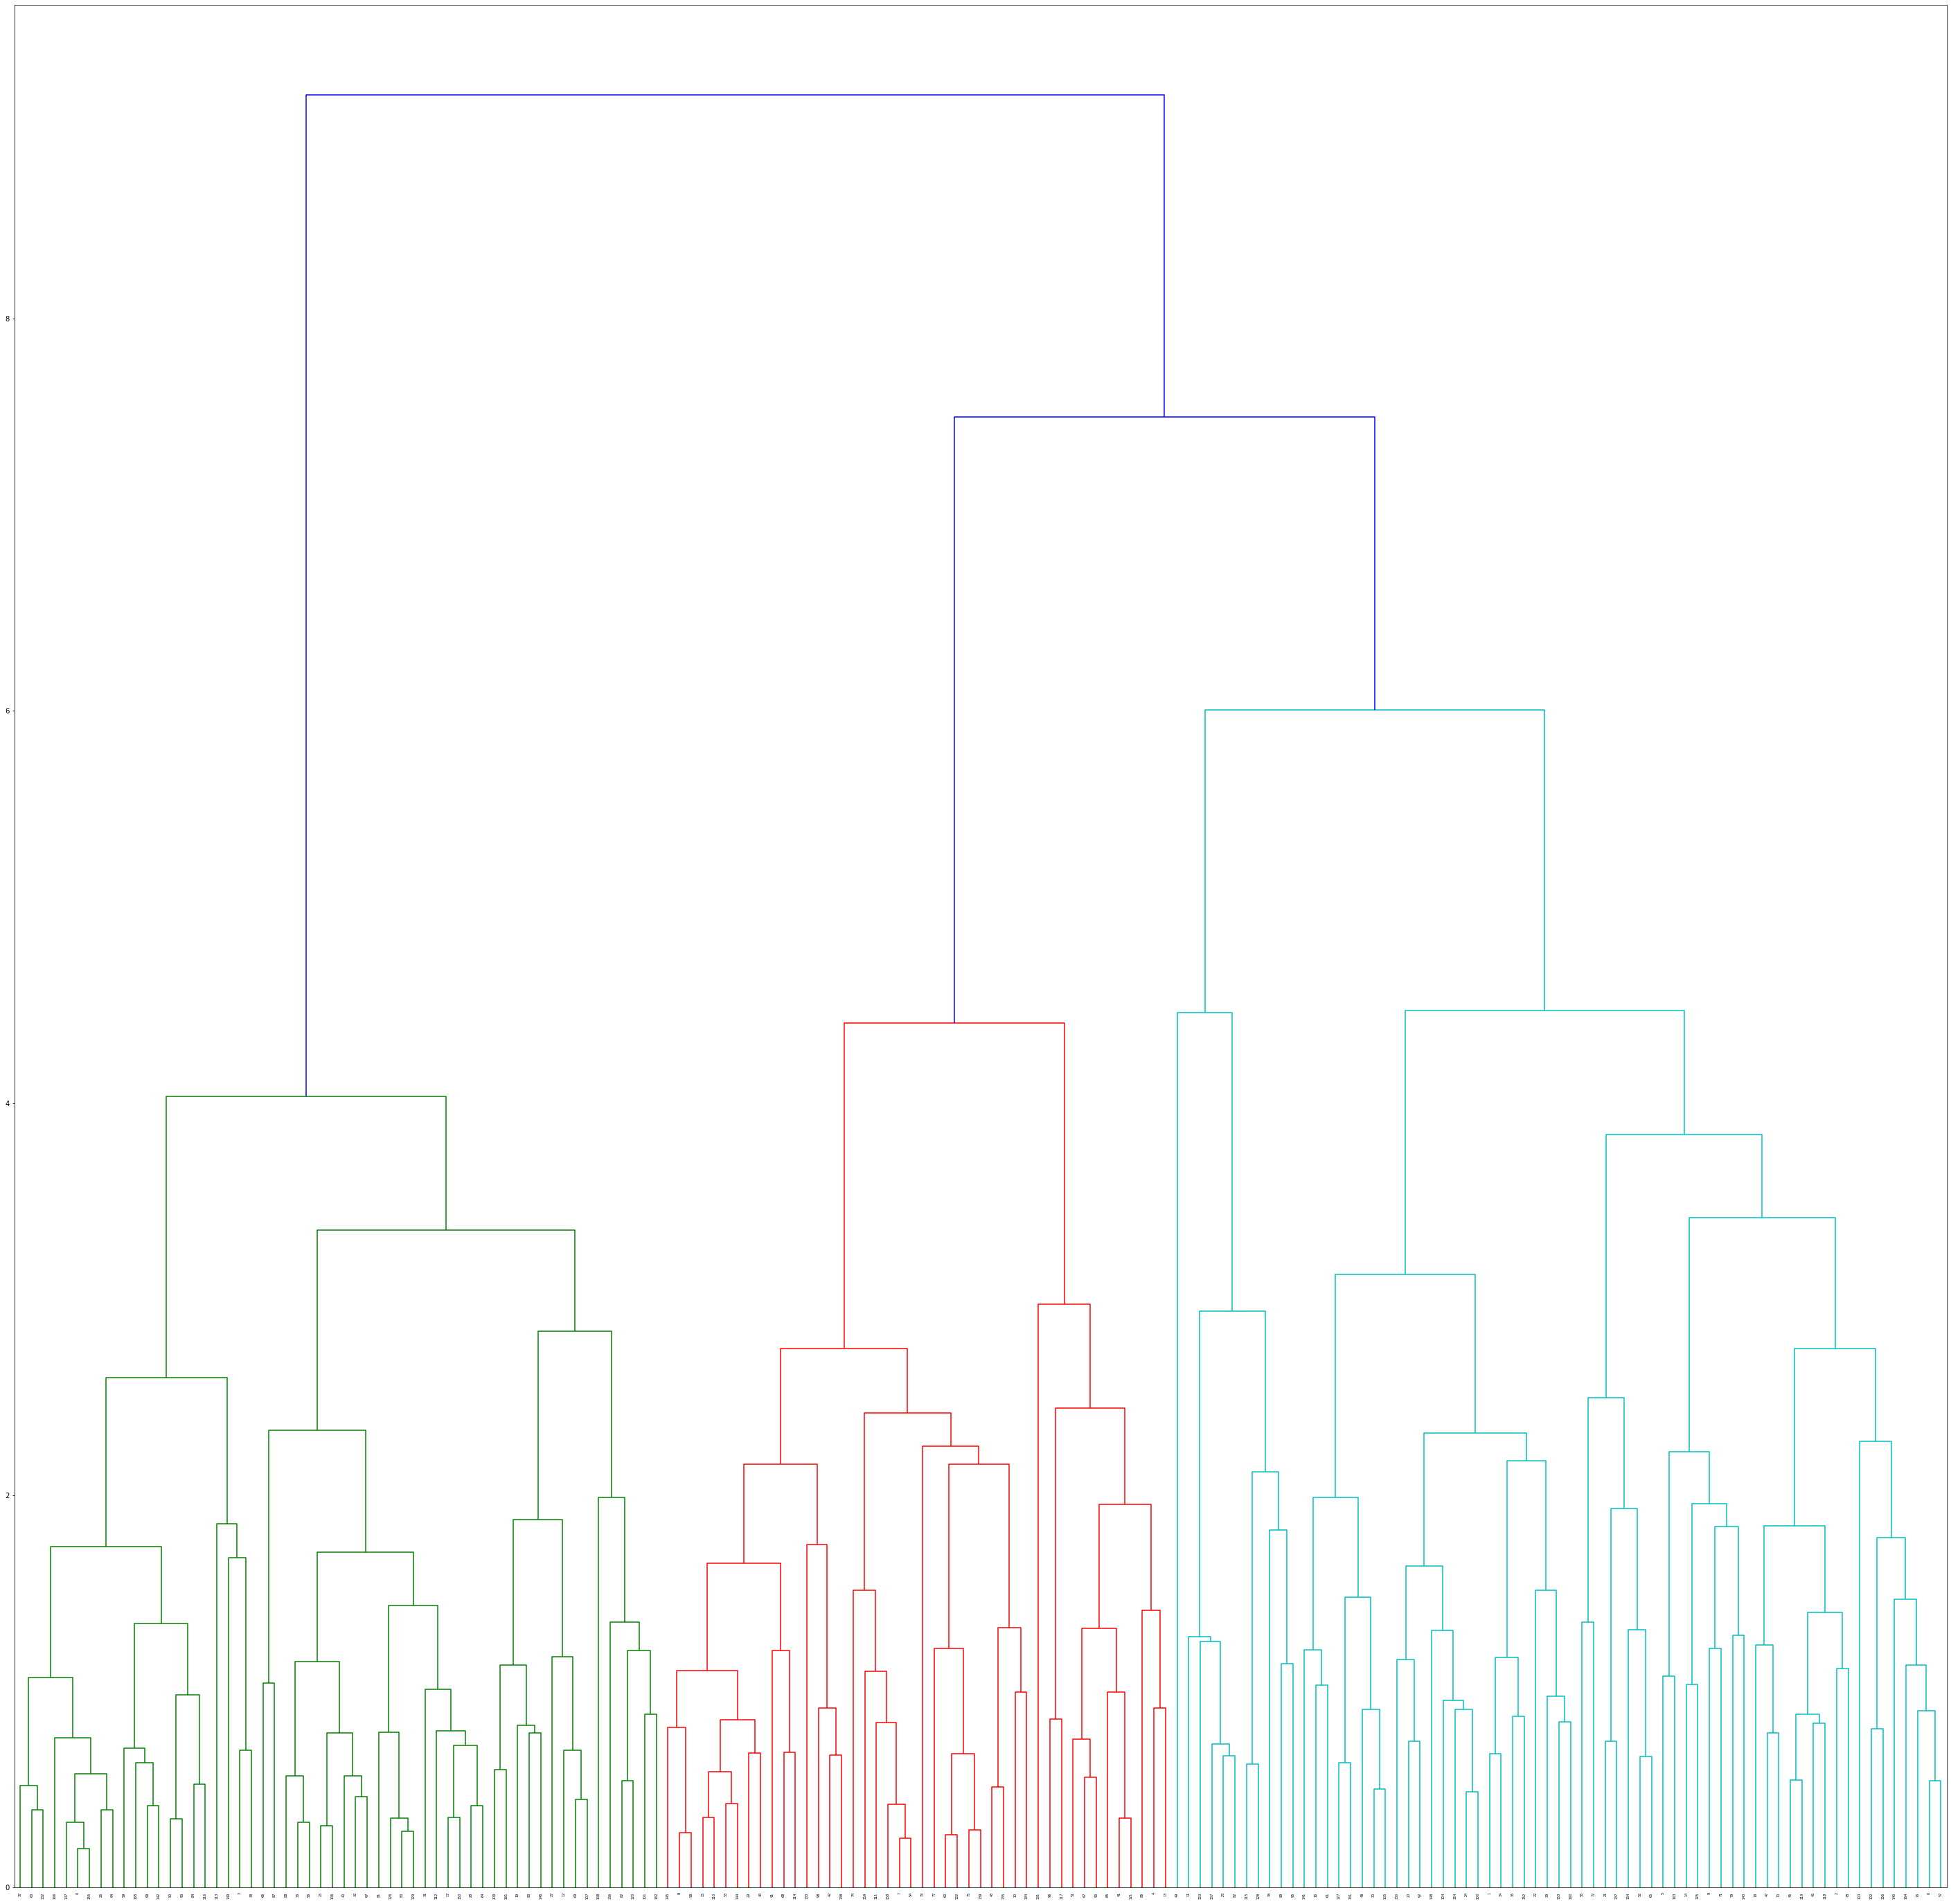

In [46]:
# complete linkage
plt.figure(figsize=(50, 50))
mergings = linkage(df_data_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [47]:
# 3 clusters -- into numpy series
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 2, 1, 1, 2, 2, 1, 2, 1, 0, 2, 1, 2, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 0, 1, 2, 0, 2, 1, 0, 0, 0, 1,
       0, 2, 2, 0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 0, 1, 0, 0, 2, 2, 0,
       0, 1, 2, 2, 1, 0, 0, 1, 2, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2,
       0, 2, 2, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 2, 2, 1, 0, 0, 1, 1, 0, 0])

In [48]:
df_data_scaled_hier=df_data_scaled.copy()
df_data_scaled_hier.drop(['group'], axis=1, inplace=True)
df_data_scaled_hier['cluster_labels'] = cluster_labels
df['cluster_labels'] = cluster_labels
df_data_scaled_hier

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,1.370383,-1.065608,-1.013379,-1.092108,-1.235169,0.640750,-1.461531,1.562228,-1.130973,0
1,-0.427361,-0.607650,-0.410155,-0.331634,-0.153769,-0.173150,0.599220,-1.009352,-0.420531,1
2,0.086520,-0.395505,-0.614410,-0.565957,0.138254,1.239008,0.632570,0.315649,-0.355866,1
3,1.611745,-0.227110,-0.844547,-0.518775,-0.627910,1.587848,-1.191690,1.647317,-0.521766,0
4,-0.791929,0.635242,0.481320,0.935379,0.600231,-0.921888,0.683137,-0.408705,0.631962,2
...,...,...,...,...,...,...,...,...,...,...
162,0.164410,-0.516249,-0.693381,-0.498000,-1.033879,-0.608407,-0.967535,0.709224,-0.627121,0
163,-0.400432,0.257662,0.370403,-0.188551,0.429662,2.266150,0.452750,-0.050238,0.737959,1
164,-0.090448,-0.687410,-0.875524,-0.716160,-0.815628,0.922881,0.106097,-0.620986,-0.964382,1
165,0.910115,-0.916358,-0.937662,-0.993058,-0.817000,1.641031,-0.562919,1.216607,-0.964382,0


In [49]:
df_data_scaled_hier.head(5)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_labels
0,1.370383,-1.065608,-1.013379,-1.092108,-1.235169,0.640750,-1.461531,1.562228,-1.130973,0
1,-0.427361,-0.607650,-0.410155,-0.331634,-0.153769,-0.173150,0.599220,-1.009352,-0.420531,1
2,0.086520,-0.395505,-0.614410,-0.565957,0.138254,1.239008,0.632570,0.315649,-0.355866,1
3,1.611745,-0.227110,-0.844547,-0.518775,-0.627910,1.587848,-1.191690,1.647317,-0.521766,0
4,-0.791929,0.635242,0.481320,0.935379,0.600231,-0.921888,0.683137,-0.408705,0.631962,2


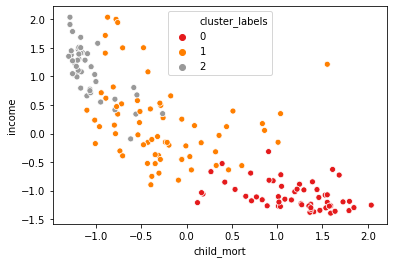

In [50]:
# Child_mortality is highest for Group 0 and lowest for Group 2, as gdpp increases child_mort decreases

sns.scatterplot(x='child_mort', y='income', hue='cluster_labels', data=df_data_scaled_hier, palette='Set1')

#Group 0 - high child mortality, low gdpp, low income 
#Group 1 - Low child mortality, between group 1 and 2
#Group 2 - low child mortality, high gdpp, high income 

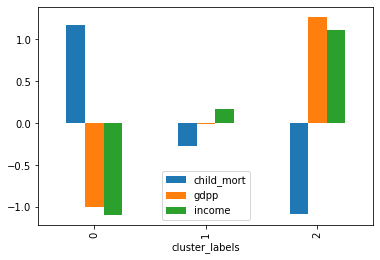

In [51]:
df_data_scaled_hier.groupby("cluster_labels")['child_mort', 'gdpp', 'income'].mean().plot(kind="bar") 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000222020C9788>,
      dtype=object)

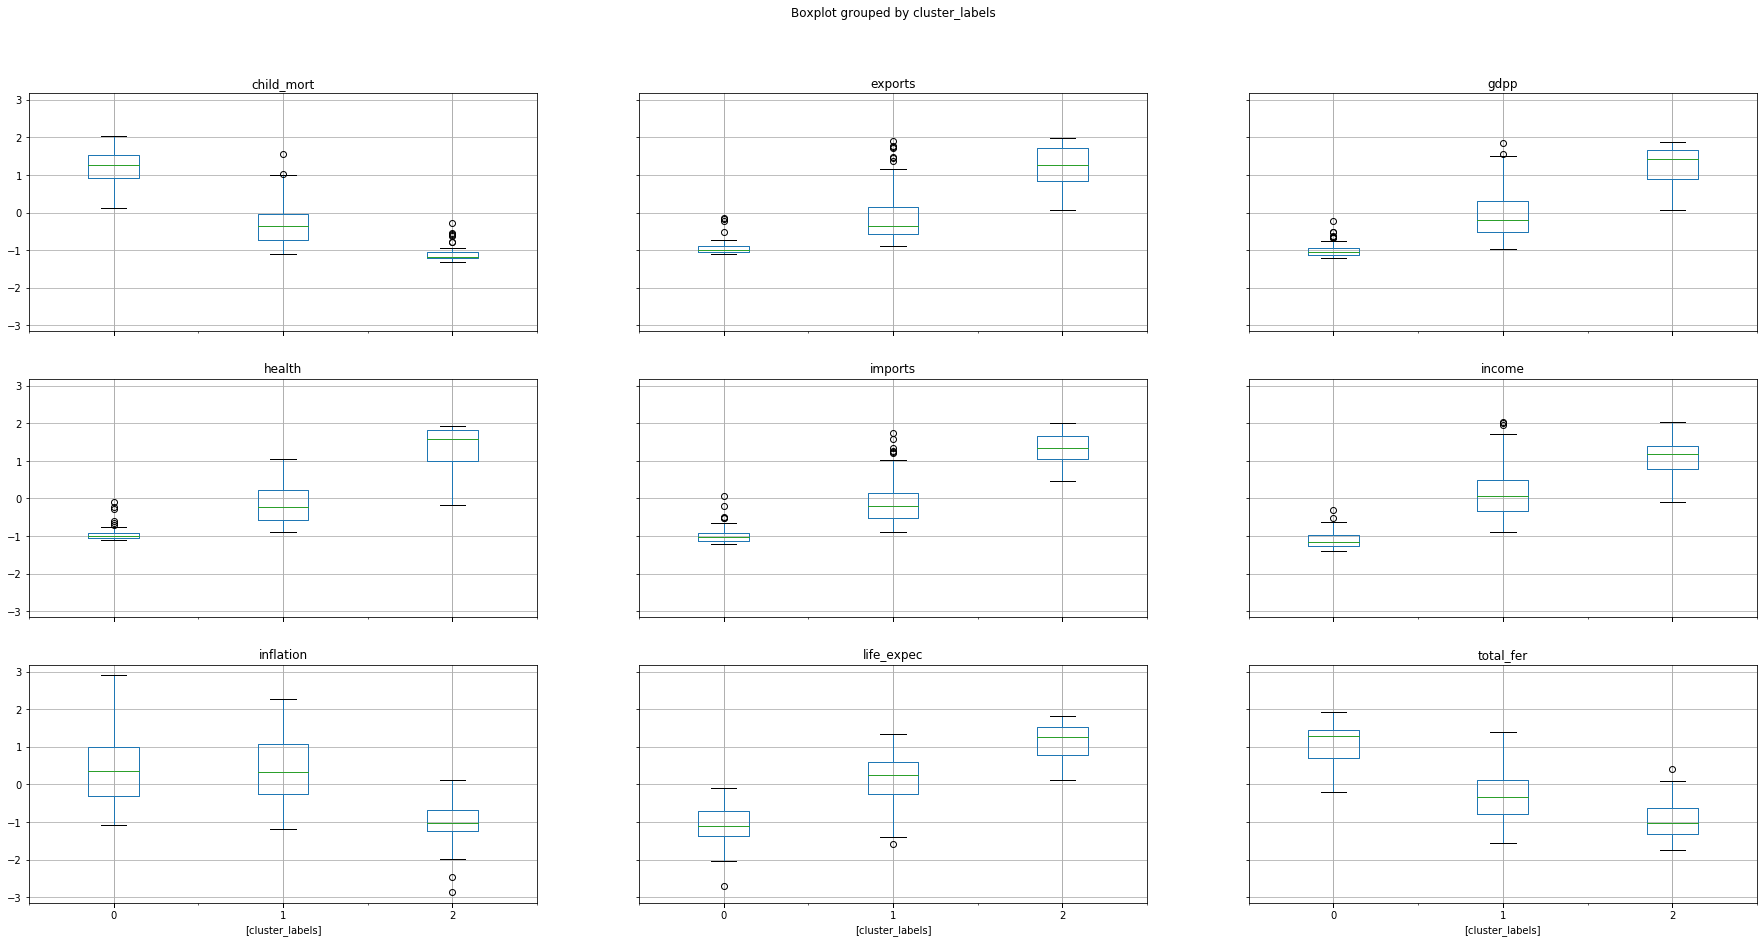

In [52]:
#Group 0 - high child mortality, low gdpp, low income, low life_expec, high total_fer, low import and export
#Group 1 - This has values intermediate between Group 2 and Group 1
#Group 2 - low child mortality, high gdpp, high income, low fertility, high life_expec and high import, export and health
df_data_scaled_hier.boxplot(by = 'cluster_labels',layout=(3,3), figsize=(30, 15))

In [53]:
# Identify top countries requiring aid
df[df.cluster_labels==0].sort_values(by=['child_mort','gdpp','income'], ascending=[False, True, True]).head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group,cluster_labels
66,Haiti,208.0,101.286,45.7442,428.314,1500.0,5.45,32.1,3.33,662.0,0,0
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0,0
32,Chad,150.0,330.096,40.6341,390.195,1930.0,6.39,56.5,6.59,897.0,0,0
31,Central African Republic,149.0,52.628,17.7508,118.190,888.0,2.01,47.5,5.21,446.0,0,0
97,Mali,137.0,161.424,35.2584,248.508,1870.0,4.37,59.5,6.55,708.0,0,0


In [ ]:
### Completed ###